# Продажи компьютерных игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Информация хранится в файле **games.csv**. Он содержит таблицу со следующими столбцами:
- `Name` — название игры
- `Platform` — название платформы
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
def read_dataset(name_csv):
    try:
        df = pd.read_csv(f'/datasets/{name_csv}') #пробуем открыть путь на Linux
    except:
        df = pd.read_csv(f'datasets/{name_csv}') #пробуем открыть путь на Windows, если не получилось на Linux
    return df
games=read_dataset("games.csv")

**Выведем первые 10 строчек датафрейма `games` на экран.**

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


**Выведем основную информацию о датафрейме `games` с помощью метода `info()`:**

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод: датафрейм `games` содержит 16715 строк и 10 столбцов. Видно, что в 6 столбцах датафрейма присутствуют пропуски, название столбцов приведено не в стиле `snake_case`, в датафрейме в некоторых столбцах необходимо заменить тип данных. Поэтому датафрейм нуждается в предобработке.**

## Предобработка данных

### Изменение названия столбцов

**Название столбцов приведём к стилю `snake_case`.**

In [5]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Изменение типов данных

**Проанализировав исходные данные, необходимо поменять типы следующих столбцов:**
- `user_score`, **object -> float32**, не имеет смысл числовые значения хранить в строке
- `year_of_release`, **float64 -> uint16**, данный тип позволит хранить любой год до 65535

**Прежде, чем менять тип со строки на float необходимо убедиться, что все значения конвертируются в тип с плавающей запятой. Выведем все уникальные значения столбца `user_score`**

In [6]:
games.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Кроме строк, которые легко конвертируются в `float` есть значение `tbd`. Это сокращение от словосочетания "to be determined", что означает "будет определено". Оптимальнее всего заменить на значение numpy.nan**

In [7]:
games.loc[games.user_score=='tbd','user_score']=np.nan

In [8]:
games.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

**Замена прошла безошибочно, значение `tbd` заменилось на `nan`, меняем тип на `float32`**

In [9]:
games.user_score = games.user_score.astype('float32')
games.user_score.dtype

dtype('float32')

**Столбец `year_of_release` содержит пропуски, поэтому невозможно поменять тип на `int16`**

**Так как float64 может хранить не больше 1.8E+308, а float32 - 3.4E+38, то вместо float64 для экономии памяти можно заменить на float32, этого типа будет достаточно для хранения всех данных. Проверку при этом проведём.**

In [10]:
for col in games.columns:
   if games[col].dtype=='float64' and games[col].max()<3e+38:    
    games[col] = games[col].astype('float32')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float32
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float32
 5   eu_sales         16715 non-null  float32
 6   jp_sales         16715 non-null  float32
 7   other_sales      16715 non-null  float32
 8   critic_score     8137 non-null   float32
 9   user_score       7590 non-null   float32
 10  rating           9949 non-null   object 
dtypes: float32(7), object(4)
memory usage: 979.5+ KB


### Устранение пропусков

**Выведем количество пропущенных значений для каждого столбца**

In [11]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

**В столбцах `name` и `genre` одинаковое количество пропусков. Выведем эти строки.**

In [12]:
games.query('name.isna() or genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


**Учитывая, что без столбца `name` вся строка теряет какой-либо смысл, то скорее всего данные пропуски связаны с какой-то проблемой в хранении данных. Удалим эти строки, т.к. в них много пропусков в других колонках.** 

In [13]:
games = games.dropna(subset=['name','genre'])
games[['name','genre']].isna().sum()

name     0
genre    0
dtype: int64

**Данные в столбце `year_of_release` имеют пропуски скорее всего из-за того, что в некоторых базах данных год релиза не указывался. Оценим какая доля от всего датафрейма у них**

In [14]:
print(f"{games.query('year_of_release.isna()').shape[0]/games.shape[0]:.1%}")

1.6%


**Количество строк небольшое, всего 1.6%. Удаляем**

In [15]:
games=games.dropna(subset=['year_of_release'])
games.year_of_release.isna().sum()

0

**Учитывая, что рейтинг ESRB распостранён только в США и Канаде, то пропуски возникли скорее всего из-за того, что часть игр произвели не для рынков США и Канады. Пропуски в столбце `rating` можно заменить значением `undef` (от слова undefined - "неопределённый")**

In [16]:
games.rating=games.rating.fillna('undef')
games.rating.isna().sum()

0

**В столбцах `critic_score`, `user_score` пропусков больше половины, вполне возможно, что оценки пользователей и критиков для некоторых игр на определённых платформах не выставлялись вообще. Учитывая, что рейтинги могут разниться даже для одной игры на разных платформах, то пропуски заменить невозможно. По этой причине их лучше всего оставить.**

### Изменение типов данных (продолжение)

**Так как пропусков в столбце `year_of_release` больше нет, то поменяем тип с `float32` на `int16`.**

In [17]:
games.year_of_release = games.year_of_release.astype('int16')
games.year_of_release.dtype

dtype('int16')

### Устранение дубликатов

**Посчитаем суммарное количество полных дубликатов**

In [18]:
games.duplicated().sum()

0

**Посмотрим сколько дубликатов в столбцах `name`, `platform` и `year_of_release`. Сочетание этих столбцов гарантирует, что игра одна и та же.**

In [19]:
games[['name','platform','year_of_release']].duplicated().sum()

1

**Посмотрим на строки с неявными дубликатами**

In [20]:
dubl_cond = games[['name','platform','year_of_release']].duplicated(keep=False)
games.loc[dubl_cond]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


**Видно, что все столбцы в этих строках совпадают за исключением объёмов продаж. Эти колонки просуммируем.**

In [21]:
games.loc[dubl_cond,['na_sales','eu_sales','jp_sales','other_sales']] = \
list(games.loc[dubl_cond,['na_sales','eu_sales','jp_sales','other_sales']].sum())
games.loc[dubl_cond]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


**Теперь неявный дубликат стал явным, удалим его**

In [22]:
games=games.drop_duplicates().reset_index(drop=True)
games[['name','platform','year_of_release']].duplicated().sum()

0

### Суммарные продажи во всех регионах

In [23]:
games['sum_sales'] = games[['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,NaN,NaN,undef,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.0,E,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,NaN,NaN,undef,31.380001


### Результаты предобработки

**Посмотрим, что получилось у нас после предобработки:**

In [24]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int16  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float32
 5   eu_sales         16443 non-null  float32
 6   jp_sales         16443 non-null  float32
 7   other_sales      16443 non-null  float32
 8   critic_score     7982 non-null   float32
 9   user_score       7462 non-null   float32
 10  rating           16443 non-null  object 
 11  sum_sales        16443 non-null  float32
dtypes: float32(7), int16(1), object(4)
memory usage: 995.7+ KB


In [25]:
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,NaN,NaN,undef,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.0,E,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,NaN,NaN,undef,31.380001
5,Tetris,GB,1989,Puzzle,23.200001,2.260000,4.22,0.58,NaN,NaN,undef,30.260000
6,New Super Mario Bros.,DS,2006,Platform,11.280000,9.140000,6.50,2.88,89.0,8.5,E,29.799999
7,Wii Play,Wii,2006,Misc,13.960000,9.180000,2.93,2.84,58.0,6.6,E,28.910000
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.440000,6.940000,4.70,2.24,87.0,8.4,E,28.319998
9,Duck Hunt,NES,1984,Shooter,26.930000,0.630000,0.28,0.47,NaN,NaN,undef,28.309999


In [26]:
games.duplicated().sum()

0

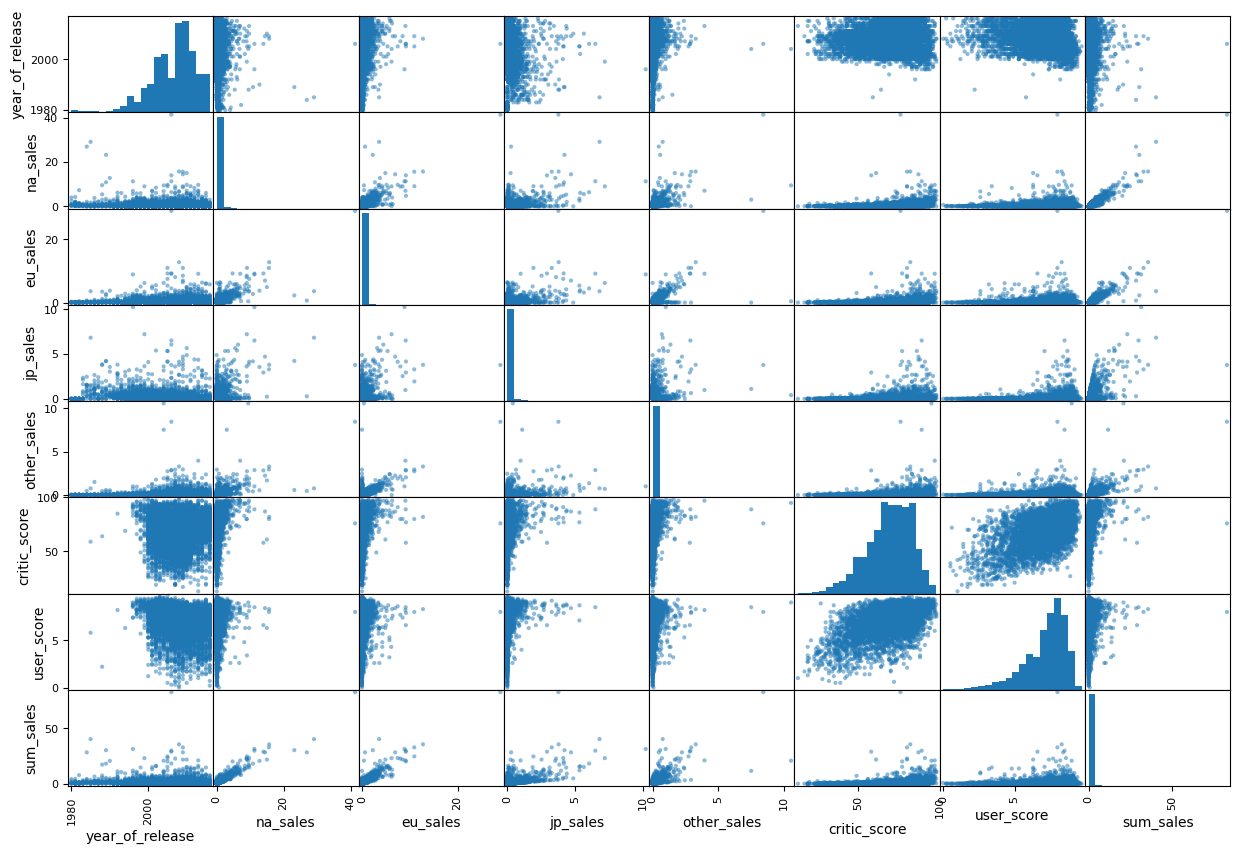

In [35]:
pd.plotting.scatter_matrix(games, figsize=(15,10), hist_kwds={'bins':20});

**В результате предобработки была проделан следующая работа:**
1. названия всех столбцов привели к стилю `snake_case`;
1. удалены строки с пропусками в столбцах `name`, `genre`, `year_of_release`, т.к. они составляли небольшую часть от всех данных в датафрейме;
1. пропуски в столбце `rating` заменили на значение `undef`, т.к. рейтинг ESRB используется только для игр, произведенных для США и Канады;
1. в строке `user_score` значение `tbd` заменили на `numpy.nan`;
1. изменили типы столбцов:
    - `user_score` с `object` на `float32`;
    - `year_of_release` c `float64` на `int64`;
1. устранили неявные дубликаты
1. в итоге остались только два столбца с пропусками: `user_score` и `critic_score`

## Исследовательский анализ

### Количество игр по годам

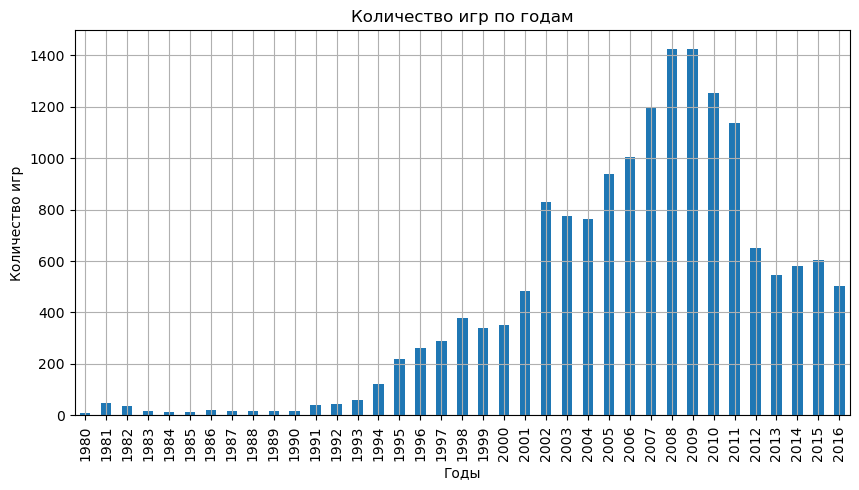

In [36]:
games.groupby('year_of_release')['name'].count().plot(kind='bar', xlabel='Годы', ylabel='Количество игр', 
                                                      title='Количество игр по годам', grid=True, figsize=(10,5));

**Из графика видно, что до 1994 года количество игр не превышало 200 в год. Максимальное количество игр было выпущено в 2008-2009 годах. В 2012 году количество игр резко снизилось и вплоть до 2016 выпускается примерно 600 игр в год.**

### Изменение продаж по платформам

**Выведем топ-5 самых популярных платформ и построим распределение продаж по годам для них**

In [37]:
top_sales_platform=games.groupby('platform')['sum_sales'].sum().sort_values(ascending=False).head()
top_sales_platform

platform
PS2     1233.559937
X360     961.239990
PS3      931.339966
Wii      891.179993
DS       802.780029
Name: sum_sales, dtype: float32

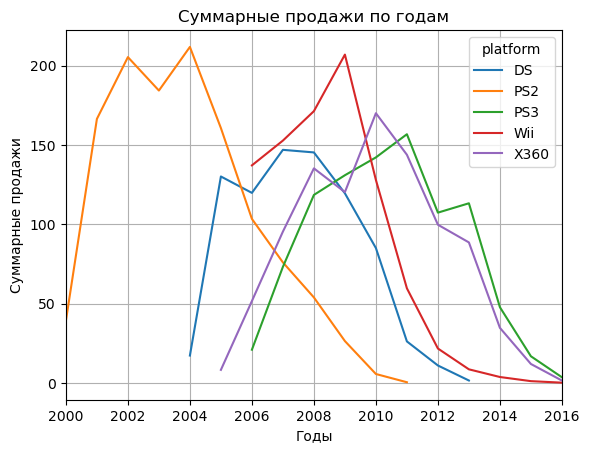

In [38]:
(
    #выбираем топ-5 платформ, группируем по годам и строим график
    games.query('platform in @top_sales_platform.index')          
         .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')         
         .plot(kind='line', xlim=(2000,2016), grid=True, xlabel='Годы', ylabel='Суммарные продажи',
              title='Суммарные продажи по годам')
);

**Посчитаем среднее время жизни платформы, при этом не будем учитывать платформы до 1994 года, как устаревшие**

In [39]:
time_life = games.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
time_life.columns=['min', 'max']
time_life['life'] = time_life['max'] - time_life['min'] + 1 #в срок жизни платформы, должны входить границы диапазона, 
                                                           # поэтому +1
#отсечём платформы, которые появились до 1994 года (начало бурного роста продаж) и определим медианное значение    
time_life.loc[time_life['min']>1994, 'life'].median() 

7.0

**Видно, что от появления платформы, до её исчезновения проходит в среднем 7 лет, а от появления до максимального всплеска продаж проходит обычно 3-4 года.**

**Учитывая распределение продаж по годам и время жизни платформ, для прогнозирования для 2017 года необходимо взять данные за 2013-2016 года.**

### Потенциально прибыльные платформы

**Возьмём актуальные данные и построим график завивисимости продаж от года**

In [40]:
actual_games=games[games.year_of_release>=2013].reset_index(drop=True)
actual_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.049999
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.270000
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,undef,14.630000
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,undef,14.599999
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.620001


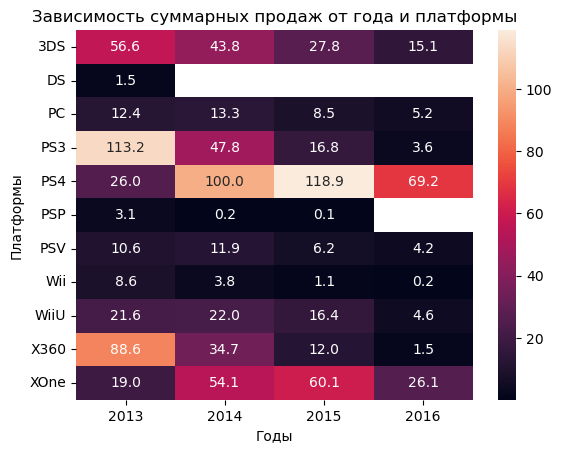

In [41]:
#построим тепловую карту зависимости суммарных продаж от года и платформы
sales_by_platform=actual_games.pivot_table(index='platform', columns='year_of_release', values='sum_sales', aggfunc='sum')
sns.heatmap(sales_by_platform, annot=True, fmt='.1f');
plt.title('Зависимость суммарных продаж от года и платформы');
plt.xlabel('Годы');
plt.ylabel('Платформы');

**Учитывая, что за 2016 год данные могут быть неполными, то потенциально прибыльными можно считать 3 платформы: PS4, XOne и 3DS. При этом только у двух платформ продажи растут - PS4 и XOne, остальные падают.** 

### Глобальные продажи игр в разбивке по платформам

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам**

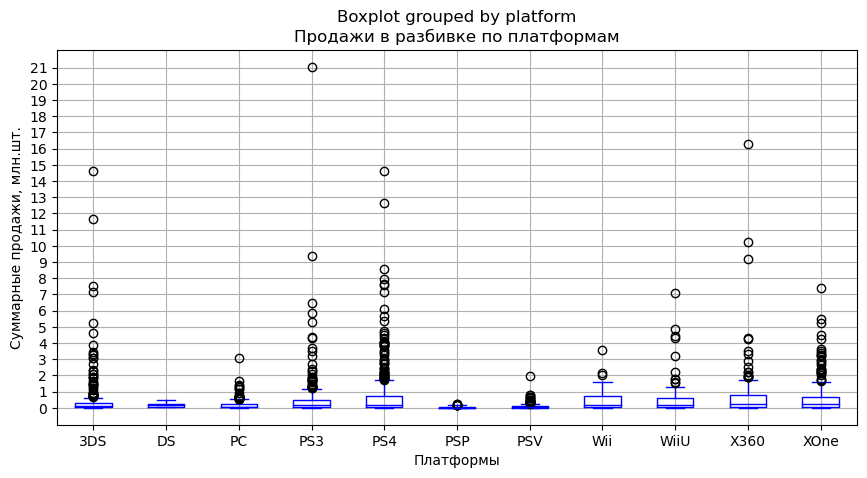

In [42]:
actual_games.boxplot(column='sum_sales', by='platform',figsize=(10,5), color='blue');
plt.title('Продажи в разбивке по платформам');
plt.xlabel('Платформы');
plt.ylabel('Суммарные продажи, млн.шт.');
plt.yticks(np.arange(0,22, step=1));

**На фоне выбросов не видны медиана и 75% квантиль, поэтому рассмотрим более укрупнённо.**

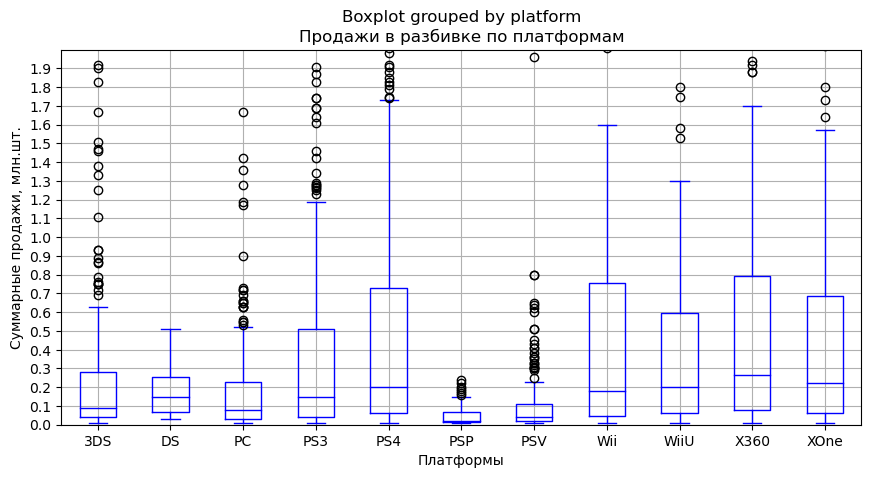

In [43]:
actual_games.boxplot(column='sum_sales', by='platform',figsize=(10,5), color='blue');
plt.title('Продажи в разбивке по платформам');
plt.xlabel('Платформы');
plt.ylabel('Суммарные продажи, млн.шт.');
plt.yticks(np.arange(0,2, step=0.1));
plt.ylim(0,2);

**Выводы:**
1. 75% игр на любой платформе не продаётся больше, чем 800 тыс. копий;
1. средние продажи каждой игры - не более 300 тыс. копий;
1. у большинства платформ есть небольшое количество игр, суммарные продажи которых значительно превышают 1 млн. копий;
1. на платформах DS, PSP и PSV основная часть игр с количеством продаж меньше 500 тыс. копий;
1. на 3 платформах (3DS, PS4, X360) есть игры с количеством проданных копий более 10 млн.

### Влияние отзывов на продажи самой популярной платформы

**Возьмём самую популярную игровую платформу за 2013-2016 года `PS4` и определим для неё влияние отзывов пользователей и критиков на суммарные продажи.**

**Построим диаграмму рассеяния между оценками пользователей и суммарными продажами.**  

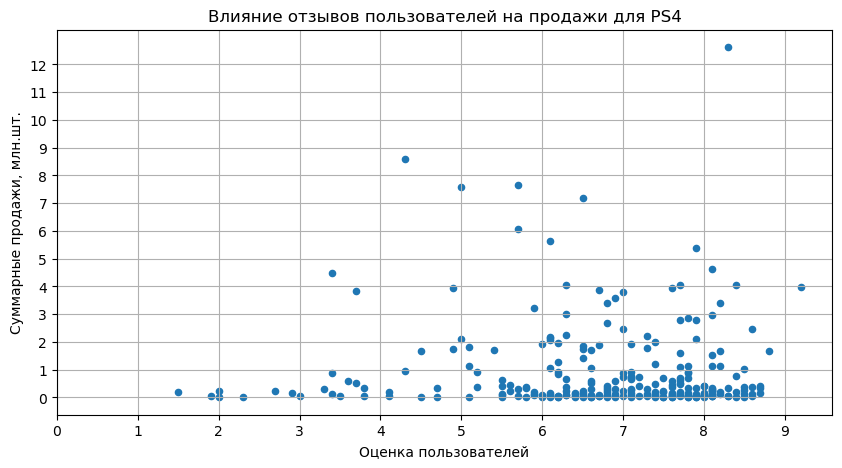

In [44]:
actual_games.query("platform=='PS4'").plot.scatter(x='user_score', y='sum_sales', grid=True, 
                                                   title='Влияние отзывов пользователей на продажи для PS4', 
                                                   xlabel='Оценка пользователей', xticks=np.arange(0,10,1),
                                                   ylabel='Суммарные продажи, млн.шт.', yticks=np.arange(0,13,1),
                                                   figsize=(10,5));

**Построим диаграмму рассеяния между оценками критиков и суммарными продажами.**

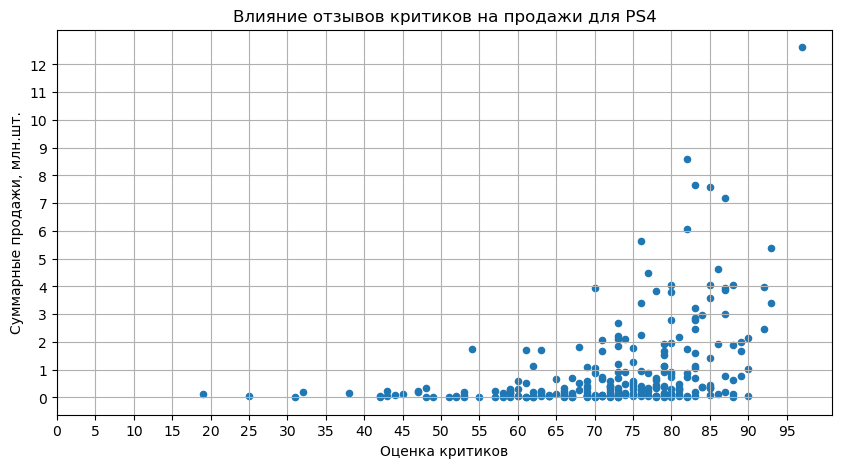

In [45]:
actual_games.query("platform=='PS4'").plot.scatter(x='critic_score', y='sum_sales', grid=True, 
                                                   title='Влияние отзывов критиков на продажи для PS4', 
                                                   xlabel='Оценка критиков', xticks=np.arange(0,100,5),
                                                   ylabel='Суммарные продажи, млн.шт.', yticks=np.arange(0,13,1),
                                                   figsize=(10,5));

**Посчитаем корреляцию между отзывами и продажами для платформы `PS4`**

In [46]:
actual_games.loc[(actual_games.platform=='PS4'), ['critic_score', 'user_score', 'sum_sales']].corr()

,critic_score,user_score,sum_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
sum_sales,0.406568,-0.031957,1.000000


**Выводы:**
1. связи между пользовательскими оценками и суммарными продажами практически нет;
1. между оценками критиков и суммарными продажами есть средняя связь;
1. игры с пользовательскими оценками меньше 3 не достигают и 1 млн. проданных копий;
1. игры с оценкой критиков меньше 50 не продаются тиражом более чем 1 млн копий, а с оценкой критиков меньше 65 суммарные продажи не превышают 2 млн копий;
1. игры с оценкой критиков больше 90 не продаются тиражом меньше, чем 2 млн копий;
1. с пользовательской оценкой больше 9 всего одна игра.

### Влияние отзывов на продажи менее популярных платформ

**Определим топ-5 платформ по суммарным продажам**

In [47]:
top_platform = actual_games.groupby('platform')['sum_sales'].sum().sort_values(ascending=False).head() 
top_platform

platform
PS4     314.140015
PS3     181.429993
XOne    159.320007
3DS     143.250000
X360    136.800003
Name: sum_sales, dtype: float32

**Построим диаграммы рассеяния между оценками пользователей и суммарными продажами.**

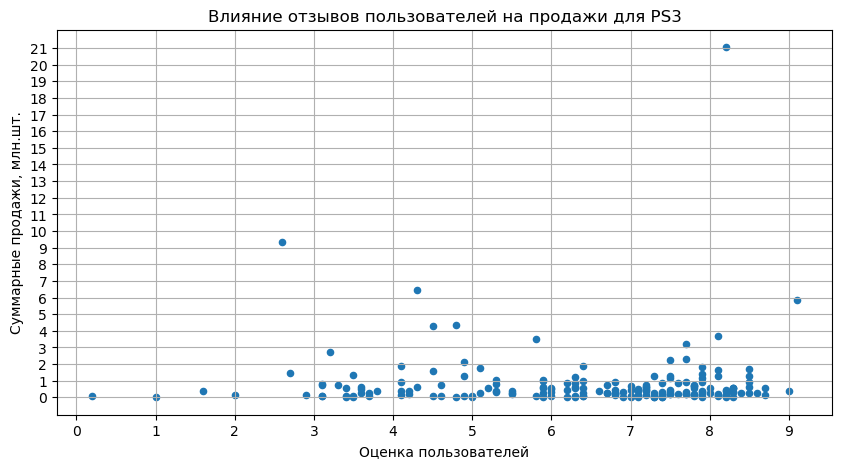

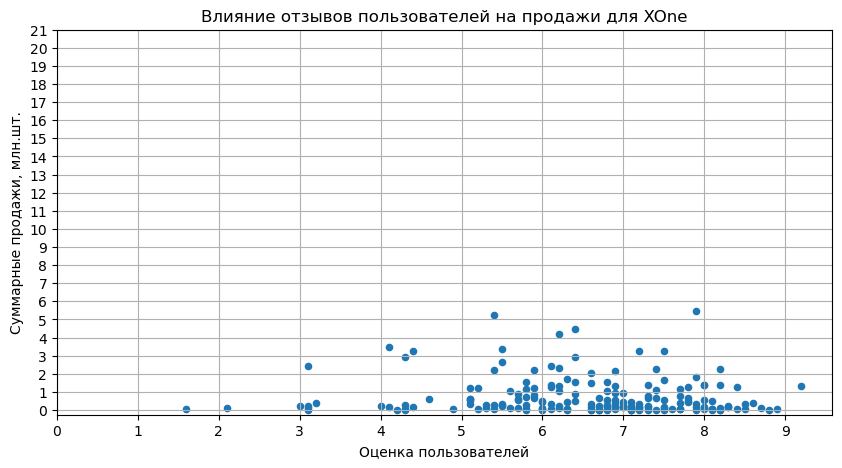

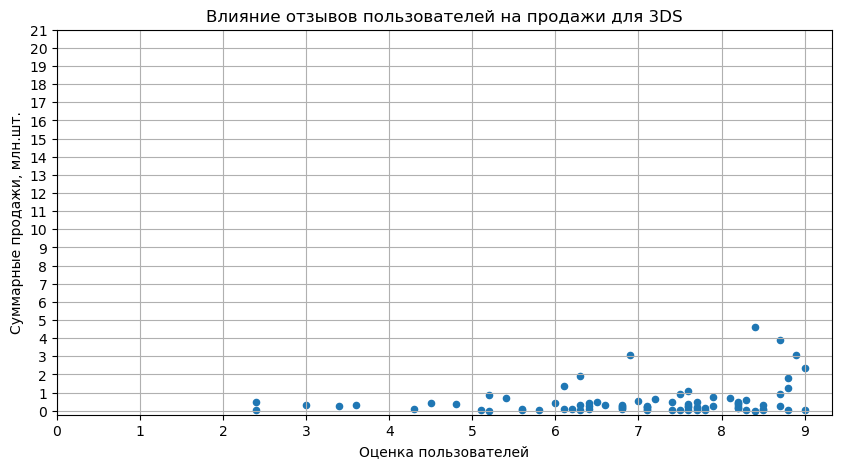

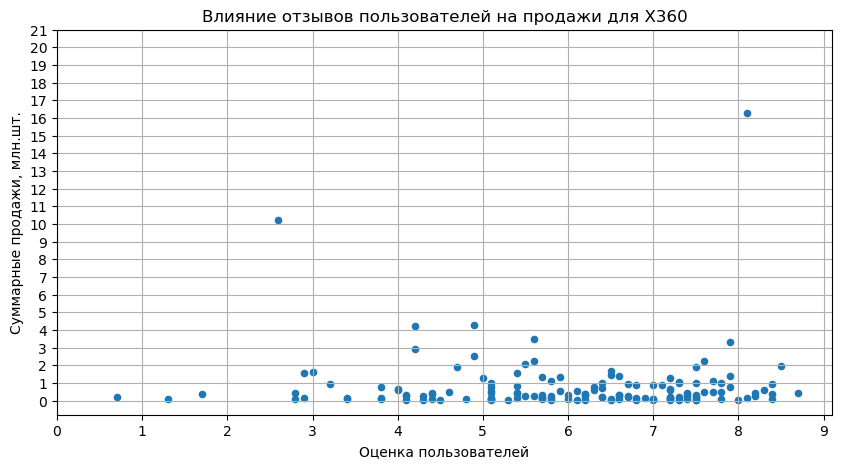

In [48]:
for platform in top_platform.keys()[1:]:
    (
        actual_games.query("platform==@platform")
                    .plot.scatter(x='user_score', y='sum_sales', grid=True, 
                                  title=f'Влияние отзывов пользователей на продажи для {platform}',
                                  xlabel='Оценка пользователей', xticks=np.arange(0,10,1), yticks=np.arange(stop=22, step=1),
                                  ylabel='Суммарные продажи, млн.шт.', figsize=(10,5))        
    ) 

**Построим диаграмму рассеяния между оценками критиков и суммарными продажами.**

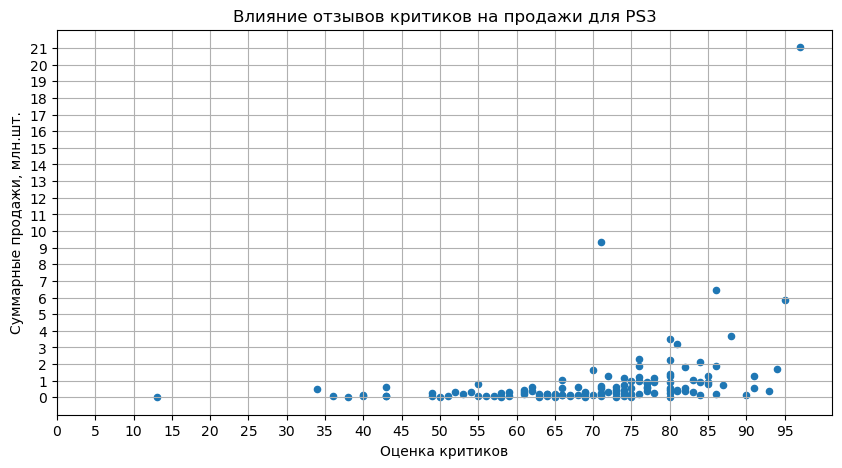

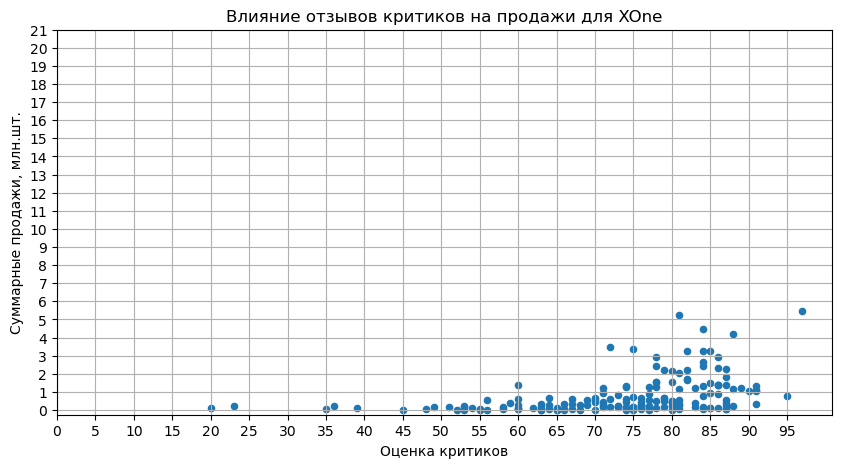

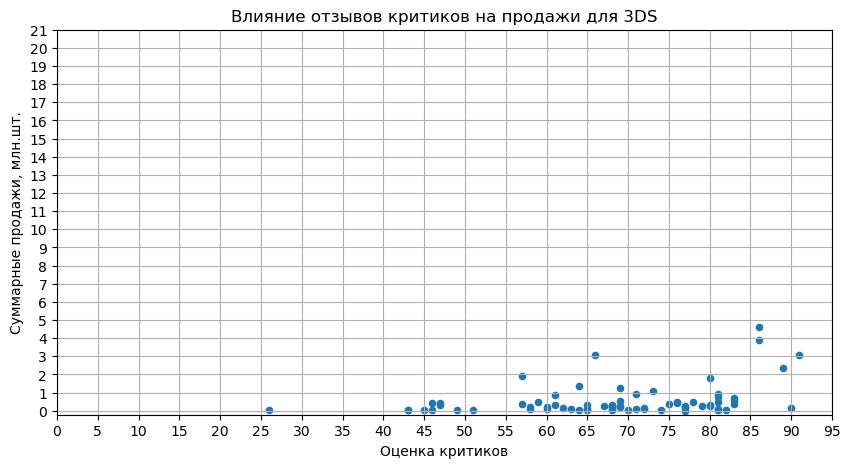

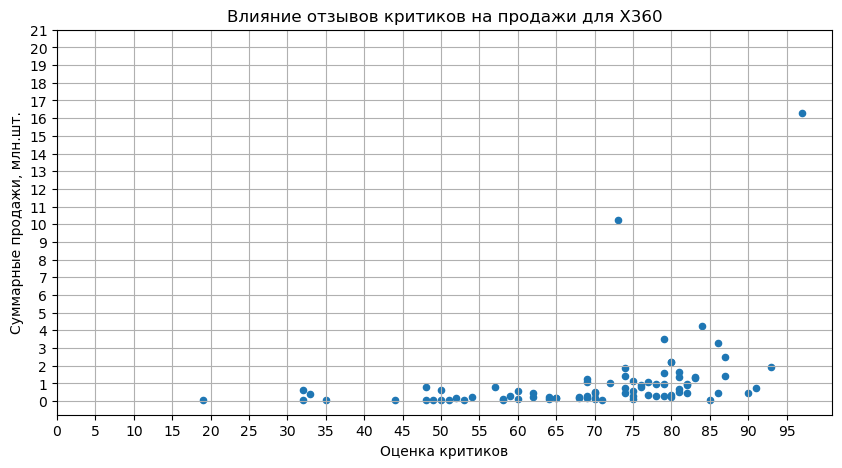

In [49]:
for platform in top_platform.keys()[1:]:
    (
        actual_games.query("platform==@platform")
                    .plot.scatter(x='critic_score', y='sum_sales', grid=True, 
                                  title=f'Влияние отзывов критиков на продажи для {platform}',
                                  xlabel='Оценка критиков', xticks=np.arange(0,100,5), yticks=np.arange(stop=22, step=1), 
                                  ylabel='Суммарные продажи, млн.шт.', figsize=(10,5))        
    ) 

**Посчитаем корреляцию между отзывами и продажами**

In [50]:
for platform in top_platform.keys()[1:]:
    print(f'Корреляция между отзывами и продажами для {platform}')
    display(actual_games.loc[(actual_games.platform==platform), ['critic_score', 'user_score', 'sum_sales']].corr())
    print()

Корреляция между отзывами и продажами для PS3


,critic_score,user_score,sum_sales
critic_score,1.000000,0.599920,0.334285
user_score,0.599920,1.000000,0.002394
sum_sales,0.334285,0.002394,1.000000



Корреляция между отзывами и продажами для XOne


,critic_score,user_score,sum_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
sum_sales,0.416998,-0.068925,1.000000



Корреляция между отзывами и продажами для 3DS


,critic_score,user_score,sum_sales
critic_score,1.000000,0.769536,0.357057
user_score,0.769536,1.000000,0.241504
sum_sales,0.357057,0.241504,1.000000



Корреляция между отзывами и продажами для X360


,critic_score,user_score,sum_sales
critic_score,1.000000,0.520946,0.350345
user_score,0.520946,1.000000,-0.011742
sum_sales,0.350345,-0.011742,1.000000


<font color='Blue'>
    <b>
        Комментарий студента: <br>
        Диаграммы рассеяния построены, расчёт корреляции выполнен, выводы подправлены
</font>

**Выводы:**
1. связи между пользовательскими оценками и суммарными продажами практически нет, значение корреляции колеблется в районе 0, за исключением платформы 3DS, которая имеет очень слабую связь (коэффициент корреляции 0.24);
1. между оценками критиков и суммарными продажами есть слабая связь (0.33-0.42);
1. игры с пользовательскими оценками меньше 2 не достигают и 1 млн. проданных копий, за исключением платформы 3DS, где нет игр с оценкой меньше 6, которые продавались тиражом больше 1 млн. копий;
1. игры с оценкой критиков меньше 55 не продаются тиражом более чем 1 млн копий;

### Влияние жанра игры на продажи

In [62]:
sales_by_genre = actual_games.pivot_table(index='genre', values='sum_sales', aggfunc=['sum', 'median', 'count'])
sales_by_genre.columns = ['sum', 'median', 'count']
sales_by_genre.sort_values('median', ascending=False)

,sum,median,count
genre,,,
Shooter,232.979996,0.450,187
Sports,150.649994,0.240,214
Platform,42.630001,0.225,74
Fighting,35.310001,0.125,80
Role-Playing,145.889999,0.125,292
Racing,39.889999,0.120,85
Action,321.869995,0.110,766
Simulation,21.760000,0.100,62
Misc,62.820000,0.100,155


**Проиллюстрируем таблицу диаграммой размаха**

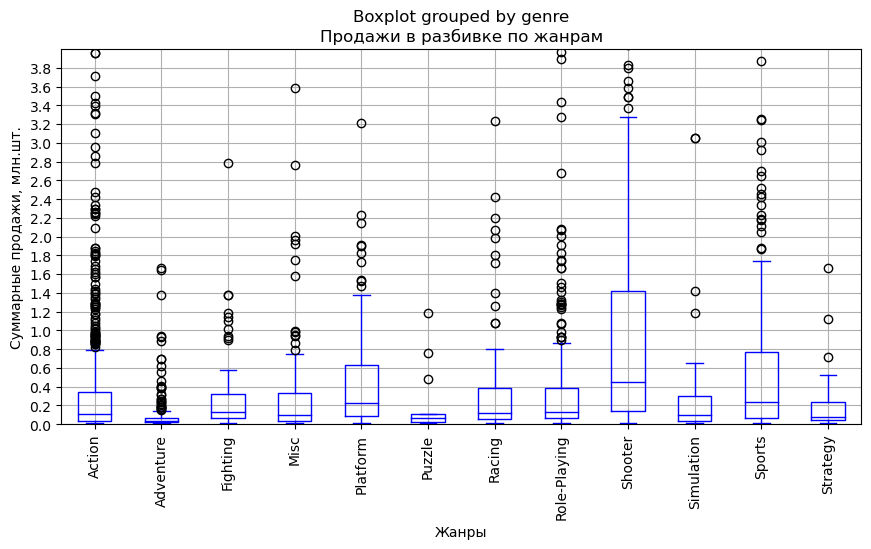

In [56]:
actual_games.boxplot('sum_sales', by='genre', rot=90, figsize=(10,5), color='blue');
plt.title('Продажи в разбивке по жанрам');
plt.xlabel('Жанры');
plt.ylabel('Суммарные продажи, млн.шт.');
plt.yticks(np.arange(stop=4, step=0.2)); 
plt.ylim(0,4); #т.к. нас не интересуют выбросы

**Выводы:**
1. самые большие суммарные продажи в жанрах экшен, шутер, а также спортивных, ролевых играх;
1. самые маленькие суммарные продажи в жанрах приключение, симуляторах, стратегиях, головоломках;
1. в жанрах шутер и спортивных играх самые большие средние продажи;
1. самые маленькие средние продажи - у жанра приключений (96 тыс. копий на 1 игру), хотя при этом количество игр в данном жанре достаточно большое (246);
1. самое большое количество выпущенных игр у жанра экшен(769), самое маленькое - у головоломок (17).

## Портрет пользователя каждого региона

**Создадим функцию для построения круговых диаграмм для каждого региона**

In [63]:
def plot_pie_region(by:str, title:str):
    title_regions={'na_sales':'Северной Америке', 'eu_sales':'Европе', 'jp_sales':'Японии', 
                   'other_sales':'других регионах'}
    df_region = actual_games.pivot_table(index=by, values=title_regions.keys(), aggfunc='sum') #группируем по регионам
    plt.figure(figsize=(10,10))
    for i, reg in enumerate(df_region, start=1):
        plt.subplot(2,2,i) 
        sort_platform = df_region[reg].sort_values(ascending=False) #сортируем по продажам
        other_platform = pd.Series(sort_platform.iloc[5:].sum(), index=['другие']) #платформы, не вошедшие в топ-5
        (
            pd.concat([sort_platform.head(5), other_platform]) #добавляем к топ-5 остальные платформы
              .plot(kind='pie', title=f'{title} в {title_regions[reg]}', ylabel='', autopct='%.1f%%')
                
        )        
plt.show()

### Самые популярные платформы 

**Построим круговые диаграммы популярности платформ для каждого региона, используя функцию `plot_pie_region`**

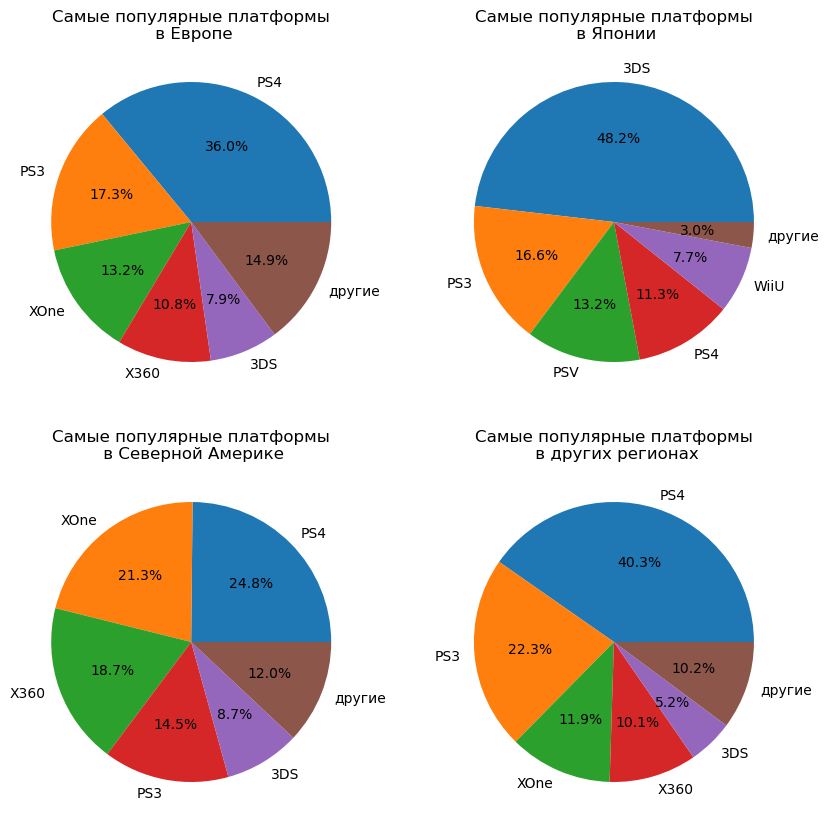

In [64]:
plot_pie_region(by='platform', title='Самые популярные платформы\n')

**Выводы:**
1. самые популярные платформы в Европе: PS4(35.9%), PS3(17.3%), XOne(13.1%), X360(10.8%), 3DS(7.9%);
1. самые популярные платформы в Японии: 3DS(48.1%), PS3(16.5%), PSV(13.2%), PS4(11.3%), WiiU(7.7%);
1. самые популярные платформы в Cеверной Америке: PS4(24.8%), XOne(21.2%), X360(18.6%), PS3(14.5%), 3DS(8.8%);
1. самые популярные платформы в других регионах: PS4(40.3%), PS3(22.3%), XOne(11.9%), X360(10.1%), 3DS(5.3%);
1. самая популярная платформа в Японии - 3DS, в остальных регионах - PS4;
1. XOne непопулярна только в Японии.

### Самые популярные жанры

**Построим круговые диаграммы популярности жанров для каждого региона, используя функцию `plot_pie_region`**

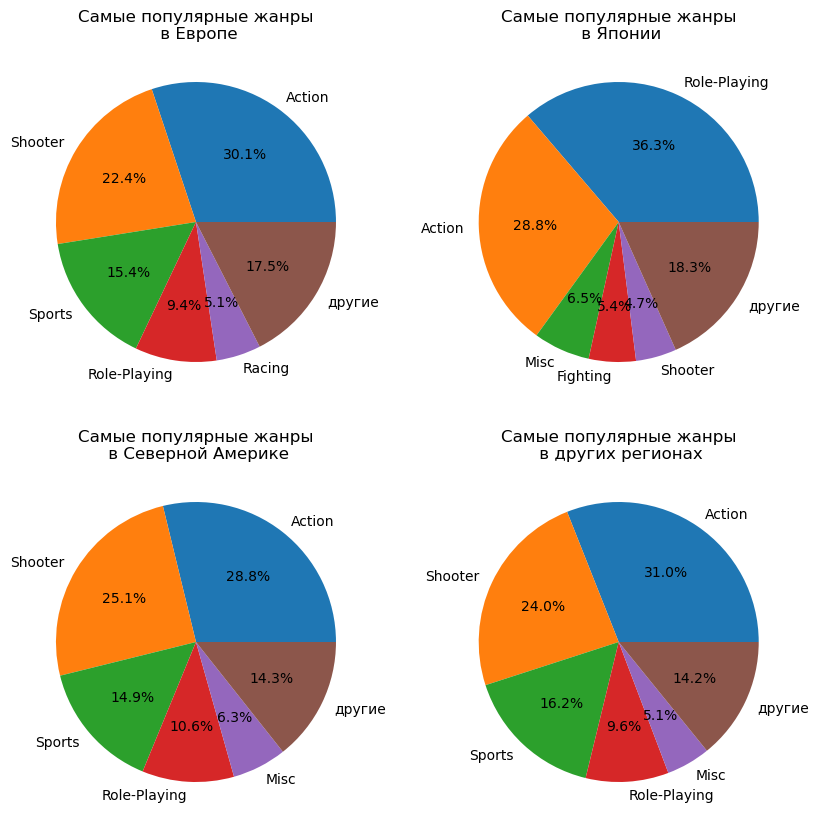

In [65]:
plot_pie_region(by='genre', title='Самые популярные жанры\n')

**Выводы:**
1. самые популярные жанры в Европе: экшен(30.2%), шутер(22.4%), спортивные(15.4%), ролевые(9.4%), гонки(5.1%);
1. самые популярные жанры в Японии: ролевые(36.2%), экшен(28.7%), разножанровые(6.7%), файтинг(5.4%), шутер(4.7%);
1. самые популярные жанры в Северной Америке: экшен(28.8%), шутер(25.0%), спортивные(14.9%), ролевые(10.6%), разножанровые(6.3%);
1. самые популярные жанры в других регионах: экшен(31.0%), шутер(24.0%), спортивные(16.2%), ролевые(9.6%), разножанровые(5.1%);
1. жанр экшен популярен во всех регионах;
1. распределение самых популярных жанров во всех регионах примерно одинаково, за исключением Японии, где ролевые игры и экшен занимают более 60% от всех игр.

### Влияние рейтинга ESRB на продажи в отдельном регионе

**Построим таблицу количества продаж в зависимости от рейтинга ESRB в каждом отдельном регионе**

In [66]:
actual_games.pivot_table(index='rating', 
                         values=['eu_sales', 'jp_sales', 'na_sales', 'other_sales'], 
                         aggfunc='sum').round()

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,83.0,15.0,79.0,23.0
E10+,43.0,6.0,54.0,13.0
M,145.0,14.0,165.0,47.0
T,42.0,21.0,50.0,14.0
undef,79.0,85.0,89.0,23.0


**Выводы:**
1. самые большие продажи игр во всех регионах, кроме Японии - для категории M;
1. в Японии основная часть игр не маркируется рейтингом ESRB, в остальных регионах доля незамаркированных игр довольно высока;
1. самые маленькие продажи игр во всех регионах, кроме Японии - для категорий E10+ и T;
1. самые маленькие продажи игр в Японии - в категории E10+.

## Проверка гипотез

**Создадим функцию, позволяющую выводить p-значение и сравнивать его с уровнем статистической значимости**

In [67]:
def check_hypothesis(pvalue, alpha):
    print('p-значение:', pvalue)
    if pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')         

### Равенство пользовательских рейтингов платформ Xbox One и PC

**Проверим равны ли пользовательские рейтинги у платформ Xbox One и PC. Так как эти две выборки можно считать независимыми (пользователи могут быть совершенно разными и даже один и тот же пользователь для разных платформ может ставить разные оценки), то необходимо проверить гипотезу о равенстве среднего двух  генеральных совокупностей для независимых выборок. В Python для этого используют метод `scipy.stats.ttest_ind`. Выдвинем гипотезы:**
- $H_0: \mu_{Xbox One}=\mu_{PC}$ (рейтинги равны)
- $H_1: \mu_{Xbox One}\neq\mu_{PC}$ (рейтинги не равны)

**Уровень статистической значимости установим в 5%. Для t-теста необходимо, чтобы дисперсии рассматриваемых генеральных совокупностей были равны. При этом достаточно, чтобы выборки были велики и равны по размеру между собой. Проверим размеры выборок пользователей с подпиской и без**        

In [68]:
#пользовательские рейтинги платформы Xbox One, при этом не учитываем игры без рейтинга
user_score_xone=actual_games.loc[(actual_games.platform=='XOne') & (~actual_games.user_score.isna()),'user_score'] 
#пользовательские рейтинги платформы PC, при этом не учитываем игры без рейтинга
user_score_pc=actual_games.loc[(actual_games.platform=='PC') & (~actual_games.user_score.isna()),'user_score']
user_score_xone.shape[0]/user_score_pc.shape[0]

1.1741935483870967

**Видно, что размер выборок отличается на 17%, поэтому в методе `ttest_ind` установим параметр `equal_var=False`**

In [69]:
results=st.ttest_ind(user_score_xone, user_score_pc, alternative='two-sided', equal_var=False)
check_hypothesis(results.pvalue, 0.05)

p-значение: 0.147597032047728
Не получилось отвергнуть нулевую гипотезу


**p-значение больше, чем уровень статистической значимости в 5%, поэтому не можем отвергнуть нулевую гипотезу. Таким образом можно утверждать, что пользовательские рейтинги у платформ Xbox One и PC примерно равны.**

**Проверим непротиворечивость нашей гипотезы на текущих выборках, для этого определим среднее значение пользовательских рейтингов для Xbox One и PC**

In [70]:
user_score_xone.mean(), user_score_pc.mean()

(6.521427154541016, 6.269676208496094)

**Разница между рейтингами мала, что в принципе подтверждает нашу гипотезу о равенстве пользовательских рейтингов для платформ Xbox One и PC**

### Средние пользовательские рейтинги жанров `Action` и `Sports` разные.

**Проверим равны ли пользовательские рейтинги у платформ `Action` и `Sports`. Так как эти две выборки можно считать независимыми, то необходимо проверить гипотезу о равенстве среднего двух  генеральных совокупностей для независимых выборок. В Python для этого используют метод `scipy.stats.ttest_ind`. Выдвинем гипотезы:**
- $H_0: \mu_{Action}=\mu_{Sports}$ (рейтинги равны)
- $H_1: \mu_{Action}\neq\mu_{Sports}$ (рейтинги не равны)

**Уровень статистической значимости установим в 5%. Для t-теста необходимо, чтобы дисперсии рассматриваемых генеральных совокупностей были равны. При этом достаточно, чтобы выборки были велики и равны по размеру между собой. Проверим размеры выборок пользователей с подпиской и без** 

In [71]:
#пользовательские рейтинги жанра Action, при этом не учитываем игры без рейтинга
user_score_action=actual_games.loc[(actual_games.genre=='Action') & (~actual_games.user_score.isna()),'user_score'] 
#пользовательские рейтинги жанра Sports, при этом не учитываем игры без рейтинга
user_score_sports=actual_games.loc[(actual_games.genre=='Sports') & (~actual_games.user_score.isna()),'user_score']
user_score_action.shape[0]/user_score_sports.shape[0]

2.43125

**Видно, что размер выборок отличается в 2.4 раза, поэтому в методе `ttest_ind` установим параметр `equal_var=False`**

In [72]:
results=st.ttest_ind(user_score_action, user_score_sports, alternative='two-sided', equal_var=False)
check_hypothesis(results.pvalue, 0.05)

p-значение: 1.4459989209941613e-20
Отвергаем нулевую гипотезу


**p-значение меньше, чем уровень статистической значимости в 5%, поэтому отвергаем нулевую гипотезу. Таким образом можно утверждать, что пользовательские рейтинги жанров экшен и спортивные разные.**

**Проверим непротиворечивость нашей гипотезы на текущих выборках, для этого определим среднее значение пользовательских рейтингов для `Action` и `Sports`**

In [73]:
user_score_action.mean(), user_score_sports.mean()

(6.83753776550293, 5.238123893737793)

**Разница между рейтингами достаточно велика (1.6), что в принципе подтверждает нашу гипотезу о том, что средние рейтинги для жанров `Action` и `Sports` отличаются.**

## Общий вывод

**В процессе исследования была проведена следующая работа:**
- предобработка данных (приведение названий столбцов к стилю `snake_case`, изменение типов данных, устранение пропусков, устранение дубликатов);
- добавлен новый столбец `sum_sales` в датафрейме `games`, показывающий суммарные продажи по всем регионам;
- изучено изменение количества продаваемых игр с течением времени;
- изучено насколько быстро в среднем устаревает игровая платформа;
- период, на котором был проведён анализ для дальнейшего прогнозирования, был определён как 2013-2016 гг.;
- оценено влияние отзывов и жанра игры на продажи;
- определены самые популярные платформы в каждом регионе;
- определены самые популярные жанры в каждом регионе;
- определено с каким рейтингом ESRB больше всего продаж в разных регионах;
- проверено несколько гипотез.

**В результате исследования были получены следующие результаты:**
- максимальное количество игр было выпущено в 2008-2009 годах, в 2012 году количество игр резко снизилось (скорее всего из-за появления игр для смартфонов) и вплоть до 2016 выпускается примерно 600 игр в год;
- от появления платформы, до её исчезновения проходит примерно 8 лет, а от появления до максимального всплеска продаж проходит обычно 3-4 года;
- самые популярные платформы к 2016 году - это PS4, XOne и 3DS;
- основная часть игр на любой платформе не продаётся больше, чем 2 млн. копий, и лишь немногие продаются больше 10 млн. копий и становятся топывыми;
- игры с пользовательскими оценками меньше 2 или с оценкой критиков меньше 50 не достигают и 1 млн. проданных копий;
- самое большое количество игр - в жанре экшен (769), при этом в жанре шутер самые большие средние продажи (в среднем одна игра продаётся тиражом в 1,24 млн копий);
- самая популярная платформа в Японии - 3DS, в остальных регионах - PS4;
- жанр экшен популярен во всех регионах;
- самые большие продажи игр во всех регионах, кроме Японии - для категории M, в Японии основная часть игр не маркируется рейтингом ESRB.

**Используя, статистический анализ, были проверены 2 гипотезы. По результатам были сформулированы следующие выводы:**
1. пользовательские рейтинги у платформ Xbox One и PC примерно равны;
1. пользовательские рейтинги жанров экшен и спортивные разные.

**Рекламный бюджет оптимальнее всего потратить на игры со следующими параметрами:**
- платформа PS4 или XOne;
- в жанре шутер;
- с рейтингом ESRB M.

**Рекламировать данные игры необходимо: для PS4 - в любом регионе, кроме Японии, а для XOne - в Северной Америке**